In [1]:
%config Completer.use_jedi = False

In [2]:
import warnings
warnings.filterwarnings('ignore')

# Ensemble

- 일련의 예측기 (즉, 분류나 회귀 모델)로부터 예측을 수집하면 가장 좋은 모델 하나보다 더 좋은 예측을 얻을 수 있다. 일련의 예측기를 **ensemble**이라고 부르기 때문에 이를 **ensemble learning**이라고 한다. 앙상블 학습 알고리즘을 **ensemble method**라고 한다.
- 앙상블 학습 알고리즘의 예시 
    - 훈련 세트로부터 무작위로 각기 다른 서브셋을 생성한다.
    - 각각의 서브셋에 일련의 결정 트리 분류기를 훈련시킨다. 
    - 모든 개별 트리의 예측을 구한다. 
    - 그런 다음 가장 많은 선택(major vote)을 받은 클래스를 예측 결과값으로 한다. 
- 결정 트리의 대표적인 ensemble에는 **Random Forest**가 있다. 간단한 방법이지만 Random Forest는 오늘날 가장 강력한 머신러닝 알고리즘 중 하나이며, 현업에서도 많이 사용된다.
- 대표적인 ensemble 기법
 - Bagging
 - Boosting
 - Stacking(ensemble의 ensemble)

---
# Ensemble 기법을 활용한 분류기 (이번 강의 노트에서 배우게 되는)
### 1. Voting based classifer
### 2. Bagging
### 3. Random Forest
---

# 1. Voting based classifier (투표 기반 분류기)
 - 더 좋은 분류기를 만드는 방법은 각 분류기의 예측을 모아서 가장 많이 선택된 클래스를 예측하는 것
 - **Hard voting** or **Soft voting** classifier : 다수결 투표로 정해지는 분류기
  - 각 개별 분류기(base classifier) 중 가장 뛰어난 분류기 보다도, 다수결 투표 분류기의 정확도가 높은 경우가 존재
  - **Base classifer가 weak learner(약한 학습기, 랜덤 추측보다 조금 더 좋은 성능을 내는 분류기)일지라도, 충분하게 많고 다양하다면 strong learner(강한 학습기, 높은 정확도를 내는 분류기)가 될 수 있음**
  - Law of large numbers(큰 수의 법칙)
    - 동전 던지기 예제 : 앞면이 나올 확률이 51%이고 뒷면이 나올 확률이 49%인 동전이 존재한다고 하자. 동전을 1,000번 던졌을 때, 앞면이 다수가 나올 확률은 얼마일까? 
    - 이항분포를 사용하자. 성공 확률이 51%인 동전을 1,000번 던졌을 때 앞면이 1번만 나올 확률은 $\frac{1000}{1} \times 0.51^{1} \times(1-0.51)^{1000-1}=1.6\times 10^{-307}$이다. 이런식으로 499까지의 확률을 더하고 1에서 빼면 된다. (즉 1에서 뒷면이 다수가 나온 경우의 확률들을 모두 빼주는 것이다.)
    - 51% 정확도를 가진 1,000개의 분류기로 앙상블 모델을 구축한다면 75%의 정확도를 기대할 수 있다. (분류기가 완벽하게 독립 & 오차의 상관관계가 없어야 가능)
  - Ensemble 방법은 예측기가 가능한 한 서로 독립적일 때 최고의 성능을 발휘한다. 다양한 분류기를 얻는 한 가지 방법은 **각기 다른 알고리즘으로 학습**시키는 것이다. 이렇게 하면 매우 다른 종류의 오차를 만들 가능성이 높기 때문에 앙상블 모델의 정확도를 향상시킬 수 있다.

In [2]:
# 동전 던지기 예제
from scipy import stats

print(1 - stats.binom.cdf(499, 1000, 0.51))  # 천 번 던졌을 때 앞면이 절반 이상 나올 확률
print(1 - stats.binom.cdf(4999, 10000, 0.51))  # 만 번 던졌을 때 앞면이 절반 이상 나올 확률

0.7467502275561786
0.9777976478701533


### 데이터 로딩
Skleran에서는 투표 기반 분류기를 `VotingClassifier`로 제공하고, base learner로 서로 다른 모델들을 사용할 수 있도록 해준다.

Sklearn에서 제공해주는 moon 데이터를 활용해보자.

In [3]:
import sklearn.datasets as datasets
x, y = datasets.make_moons(n_samples=1000, noise=0.3, random_state=42)

In [4]:
x[:10]

array([[-0.17186341,  0.59624885],
       [ 1.25328273, -0.26541353],
       [ 0.72322405,  0.2319425 ],
       [-0.06519764, -0.65519443],
       [-0.79949325,  0.55293543],
       [ 0.71131439,  0.07365753],
       [ 0.26252452, -0.17853072],
       [-0.17500737,  0.5947448 ],
       [ 1.54052117, -0.36735281],
       [ 0.81833812,  1.06585092]])

In [5]:
y[:10]

array([1, 1, 1, 1, 0, 1, 1, 1, 1, 0])

### 학습 / 테스트셋 구분

In [6]:
from sklearn.model_selection import train_test_split
train_x, test_x, train_y, test_y = train_test_split(x, y, random_state=42)

### <font color=blue>투표 기반 분류기 학습</font>

> **Hard voting** : Base learner의 결과값이 클래스이며, major class를 사용하여 최종 결과를 도출한다.

Base learner
 - LogisticRegression
 - DecisionTreeClassifier
 - SVC

In [7]:
from sklearn.ensemble import VotingClassifier
from sklearn.linear_model import LogisticRegression
from sklearn.tree import DecisionTreeClassifier
from sklearn.metrics import accuracy_score

# Base learner들
log_clf = LogisticRegression(solver="liblinear", random_state=42)
dt_7_clf = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_10_clf = DecisionTreeClassifier(max_depth=10, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt_7', dt_7_clf), ('dt_10', dt_10_clf)], voting='hard'
)

In [8]:
# 개별 학습기의 성능 (랜덤포레스트, 로지스틱, SVM, 다수결 기반 분류기)
for clf in (log_clf, dt_7_clf, dt_10_clf, voting_clf):
    clf.fit(train_x, train_y)
    test_pred = clf.predict(test_x)
    print(clf.__class__.__name__, accuracy_score(test_y, test_pred))

LogisticRegression 0.852
DecisionTreeClassifier 0.892
DecisionTreeClassifier 0.892
VotingClassifier 0.908


> **Soft voting** : Base learner의 결과값이 확률이며, 각 learner의 확률의 평균을 내어 최종 결과를 도출한다.

In [9]:
log_clf = LogisticRegression(solver="liblinear", random_state=42)
dt_7_clf = DecisionTreeClassifier(max_depth=7, random_state=42)
dt_10_clf = DecisionTreeClassifier(max_depth=10, random_state=42)

voting_clf = VotingClassifier(
    estimators=[('lr', log_clf), ('dt_7', dt_7_clf), ('dt_10', dt_10_clf)], voting='soft'
)

In [10]:
# 개별 학습기의 성능
for clf in (log_clf, dt_7_clf, dt_10_clf, voting_clf):
    clf.fit(train_x, train_y)
    test_pred = clf.predict(test_x)
    print(clf.__class__.__name__, accuracy_score(test_y, test_pred))

LogisticRegression 0.852
DecisionTreeClassifier 0.892
DecisionTreeClassifier 0.892
VotingClassifier 0.908


# 2. Bagging and Pasting

- **Bagging (Bootsrap Aggregating)**
 - <font color=red>훈련 세트에서 중복을 허용하여 샘플링을 하고, 그 훈련 세트에서 1개의 학습 알고리즘을 훈련 시킨 결과를 조합(평균)하는 기법</font>
 - 모든 예측기가 훈련을 마치면 앙상블은 모든 예측기의 예측을 모아서 새로운 샘플에 대한 예측을 생성
 - 분류의 경우는 통계적 최빈값(즉, hard voting classifier 처럼 가장 많은 예측 결과)을 사용
 - 회귀의 경우는 평균을 사용
 - <font color=red>개별 예측기는 원본 훈련 세트로 훈련시킨 것보다 ?훨씬 크게 편향되어 있지만? 앙상블의 결과 편향과 분산이 모두 감소 (일반적으로 앙상블 기법에서는 편향은 비슷하지만, 분산은 줄어듬)</font>
 - 병렬로 학습이 가능
- Pasting
 - 훈련 세트에서 중복을 허용하지 않고 샘플링을 하고, 그 훈련 세트에서 1개의 학습 알고리즘을 훈련 시킨 결과를 조합하는 기법

### <font color=blue>Bagging 학습</font>

In [11]:
from sklearn.ensemble import BaggingClassifier

bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    max_samples=100, bootstrap=True, n_jobs=-1
)

bag_clf.fit(train_x, train_y)
pred_y = bag_clf.predict(test_x)

In [12]:
accuracy_score(test_y, pred_y)

0.908

### 단일 Decision tree (위의 결과와 비교용)

In [13]:
tree = DecisionTreeClassifier(random_state=42)
tree.fit(train_x, train_y)
pred_y_tree = tree.predict(test_x)

In [14]:
accuracy_score(test_y, pred_y_tree)

0.892

---
*(Advanced)*

In [15]:
from matplotlib.colors import ListedColormap
import numpy as np

# Classifer를 입력으로 받고, 결정경계를 그려주는 Help 함수 입니다.
def plot_decision_boundary(clf, X, y, axes=[-1.5, 2.5, -1, 1.5], alpha=0.5, contour=True):
    x1s = np.linspace(axes[0], axes[1], 100)
    x2s = np.linspace(axes[2], axes[3], 100)
    x1, x2 = np.meshgrid(x1s, x2s)
    X_new = np.c_[x1.ravel(), x2.ravel()]
    y_pred = clf.predict(X_new).reshape(x1.shape)
    custom_cmap = ListedColormap(['#fafab0','#9898ff','#a0faa0'])
    plt.contourf(x1, x2, y_pred, alpha=0.3, cmap=custom_cmap)
    if contour:
        custom_cmap2 = ListedColormap(['#7d7d58','#4c4c7f','#507d50'])
        plt.contour(x1, x2, y_pred, cmap=custom_cmap2, alpha=0.8)
    plt.plot(X[:, 0][y==0], X[:, 1][y==0], "yo", alpha=alpha)
    plt.plot(X[:, 0][y==1], X[:, 1][y==1], "bs", alpha=alpha)
    plt.axis(axes)
    plt.xlabel(r"$x_1$", fontsize=18)
    plt.ylabel(r"$x_2$", fontsize=18, rotation=0)

In [16]:
import matplotlib.pyplot as plt

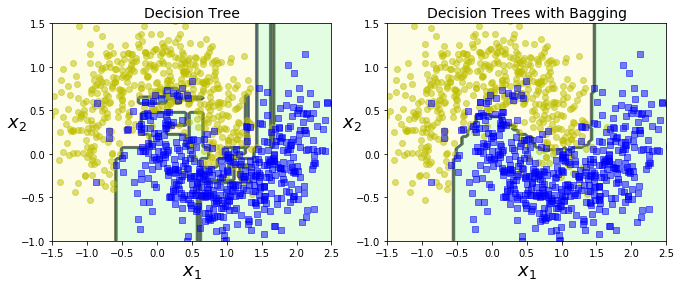

In [17]:
plt.figure(figsize=(11, 4))
plt.subplot(121)
plot_decision_boundary(tree, x, y)
plt.title('Decision Tree', fontsize=14)
plt.subplot(122)
plot_decision_boundary(bag_clf, x, y)
plt.title('Decision Trees with Bagging', fontsize=14)
plt.show()

Bagging의 경우 일반화의 성능이 더 뛰어남 (결정경계를 살펴보면)

- **<font color=red>Bootstraping은 각 예측기가 학습하는 서브셋에 다양성을 증가시키므로 bagging이 pasting보다 bias가 조금 더 높음. 하지만 이는 learner들의 상관관계를 줄이므로 앙상블의 분산을 감소시킴</font>**
- 전반적으로 bagging을 선호 (bagging과 pasting을 모두 평가해서 더 나은 쪽을 당연히 선택)

---

### OOB (out-of-bag)

배깅을 사용하면 어떤 샘플은 한 예측기를 위해 여러 번 샘플링되고 어떤 것은 전혀 선택되지 않을 가능성이 존재한다. BaggingClasiifer는 기본값으로 중복을 허용하여(with replacement) 훈련 세크의 크기 만큼인 m개 샘플을 선택한다. 이는 <U>평균적으로 각 예측기에 훈련 샘플의 63% 정도만 샘플링된다는 것을 의미</U>한다.
 - m개의 샘플에서 무작위로 하나를 추출할 때 선택되지 않을 확률이 $1-\frac{1}{m}$이고 이를 $m$번 반복했을 때도 선택되지 않을 확률은 $(1-\frac{1}{m})^m$. 로그와 로피탈 정리를 이용하면 $e^{-1}$과 같아진다. 따라서 샘플링될 확률은 $1-e^{-1}$이 된다.
 
여기서 선택되지 않은 훈련 샘플의 나머지 37%를 **oob 샘플**이라고 한다. 예측기마다 남겨진 37%는 모두 다르다.

따라서 <U>예측기가 훈련되는 동안에는 oob 샘플을 사용하지 않으므로 검증 세트나 교차 검증을 사용하지 않고 oob 샘플을 사용하여 평가할 수 있다</U>. 앙상블의 평가는 각 예측기의 oob 평가를 평균하여 얻는다.

Sklearn에서는 `oob_score_`를 이용한다.

In [18]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(random_state=42), n_estimators=500,
    bootstrap=True, n_jobs=-1, oob_score=True
)

bag_clf.fit(train_x, train_y)
bag_clf.oob_score_  # oob를 이용한 검증 점수

0.9

In [19]:
pred_oob = bag_clf.predict(test_x)
accuracy_score(test_y, pred_oob)

0.912

In [20]:
# oob sample에 대한 결과값을 볼 수 있다.
bag_clf.oob_decision_function_ 

array([[0.1746988 , 0.8253012 ],
       [0.34554974, 0.65445026],
       [1.        , 0.        ],
       ...,
       [0.98395722, 0.01604278],
       [0.82828283, 0.17171717],
       [0.        , 1.        ]])

### Random patch와 random subspace
- Random patch : 훈련 특성과 샘플을 모두 샘플링하는 것 
 - `bootstrap_features=False`, `max_samples=1.0`
- Random subspace : 훈련 특성은 샘플링하고 훈련 샘플을 모두 사용하는 것 
 - `bootstrap_features=True`, `max_samples < 1.0`

# 3. Random forest
- 랜덤 포레스트는 일반적으로 bagging 방법(또는 pasting)을 적용한 결정 트리의 앙상블이다.
- 랜덤 포레스트 알고리즘은 **트리의 노드를 분할할 때 전체 특성 중에서 최선의 특성을 찾는 대신 <font color=red>무작위로 선택한 특성 후보 중에서 최적의 특성을 찾는</font> 식으로 무작위성을 더 주입**한다.
 - 트리를 더욱 다양하게 생성 (트리의 의존성을 낮추고, 다양성을 증가)
 - 편향을 손해 보는 대신 분산을 낮추어 전체적으로 더 훌륭한 모델을 생성

Sklearn에서 제공하는 `RandomForestClassifier`을 사용하면 된다.

In [21]:
from sklearn.ensemble import RandomForestClassifier

# 16개의 리프 노드를 갖는 500개의 트리로 이루어진 랜덤 포레스트를 여러 CPU 코어에서 훈련
rnd_clf = RandomForestClassifier(n_estimators=500, max_leaf_nodes=16, n_jobs=-1, random_state=42)
rnd_clf.fit(train_x, train_y)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
            max_depth=None, max_features='auto', max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, n_estimators=500, n_jobs=-1,
            oob_score=False, random_state=42, verbose=0, warm_start=False)

In [22]:
pred_rf_y = rnd_clf.predict(test_x)
accuracy_score(test_y, pred_rf_y)

0.92

Sklearn에서 제공하는 `BaggingClassifier` 이용하여 Random forest를 구현하는 방법도 있다. `splitter="random"`을 설정하면 됩니다.

In [23]:
bag_clf = BaggingClassifier(
    DecisionTreeClassifier(splitter="random", max_leaf_nodes=16, random_state=42),
    n_estimators=500, 
    max_samples=1.0, 
    bootstrap=True, 
    n_jobs=-1, 
    random_state=42)

bag_clf.fit(train_x, train_y)

BaggingClassifier(base_estimator=DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=None,
            max_features=None, max_leaf_nodes=16,
            min_impurity_decrease=0.0, min_impurity_split=None,
            min_samples_leaf=1, min_samples_split=2,
            min_weight_fraction_leaf=0.0, presort=False, random_state=42,
            splitter='random'),
         bootstrap=True, bootstrap_features=False, max_features=1.0,
         max_samples=1.0, n_estimators=500, n_jobs=-1, oob_score=False,
         random_state=42, verbose=0, warm_start=False)

In [24]:
y_pred = bag_clf.predict(test_x)
accuracy_score(test_y, pred_rf_y)

0.92

### Extra tree

- Extremely Randomized Trees (Extra Trees) : 랜덤 포레스트에서 트리를 만들 때 각 노드는 무작위로 특성의 서브셋을 만들어 분할에 사용한다. 특성의 서브셋에 대하여, 각 특성 모두에 대해서 계산을 하고 분할에 최적화된 임계값을 찾는다(greedy search). **트리를 더욱 무작위로 만들기 위해**, 보통의 결정 트리처럼 후보 특성의 greedy search를 하여 최적의 임곗값을 찾는 대신 **후보 특성을 사용해 무작위로 분할**한 다음 그중에서 최상의 분할을 선택한다. 따라서 일반적인 랜덤 포레스트보다 엑스트라 트리가 훨씬 빠르다.
- `RandomForestClassifier` vs `ExtraTreesClassifier` : 어떤 것이 더 좋을지는 속단하기 어렵다. 일반적으로 둘 다 시도해보고 교차 검증으로 비교해보는 것이 유일한 방법이다. 그리고 그리드 탐색으로 하이퍼파라미터 튜닝을 한다.

### 특성 중요도

- 랜덤 포레스트의 또 다른 장점은 특성의 상대적 중요도를 측정하기 쉽다는 것이다.
- Sklearn은 어떤 특성을 사용한 노드가 (랜덤 포레스트에 있는 모든 트리에 걸쳐서) 평균적으로 불순도를 얼마나 감소시키는지 확인하여 특성의 중요도를 측정한다.
 - 가중치의 평균이며 각 노드의 가중치는 연관된 훈련 샘플 수와 같다.
 - 결정 트리의 특성 중요도는 노드에 사용된 특성별 information gain에서 샘플 수만 샘플 비율로 바꾸어,
 $$(\text{현재 노드의 샘플 비율} \times \text{불순도}) - (\text{쪽 자식 노드의 샘플 비율} \times \text{불순도}) - (\text{오른쪽 노드의 샘플 비율} \times \text{불순도})$$
 을 계산하여 더하고, 특성 중요도의 합이 1이 되도록 전체 합으로 나누어 정규화합니다. 여기서 샘플 비율은 트리 전체 샘플 수에 대한 비율입니다. 랜덤 포레스트의 특성 중요도는 각 결정 트리의 특정 중요도를 모두 계산하여 더한 후 트리 수로 나눈 것입니다.

In [25]:
rnd_clf.feature_importances_

array([0.43931025, 0.56068975])

Iris를 random forest를 이용하여 분류하고 난 후, feature 중요도를 구해보자.

In [26]:
# Iris data set

from sklearn.datasets import load_iris
iris = load_iris()
rnd_clf = RandomForestClassifier(n_estimators=500, n_jobs=-1, random_state=42)
rnd_clf.fit(iris["data"], iris["target"])
for name, score in zip(iris["feature_names"], rnd_clf.feature_importances_):
    print(name, score)

sepal length (cm) 0.11249225099876374
sepal width (cm) 0.023119288282510326
petal length (cm) 0.44103046436395765
petal width (cm) 0.4233579963547681


시각화를 해보자.

In [27]:
import numpy as np
import matplotlib.pyplot as plt

Text(0.5,0,'Relative Importance')

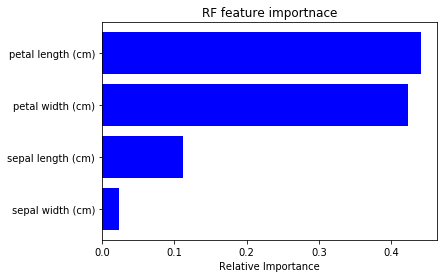

In [28]:
rf_feat_importance = rnd_clf.feature_importances_
indices = np.argsort(rf_feat_importance)

plt.title('RF feature importnace')
plt.barh(range(len(indices)), rf_feat_importance[indices], color='b', align='center')
plt.yticks(range(len(indices)), np.array(iris["feature_names"])[indices])
plt.xlabel('Relative Importance')